In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"

sys.path.append(dir_KLens)
from KLtool import *

sys.path.append(dir_TNGcube)
from TNGcube import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
subhalo = pickle.load(open('../notebooks/subhalo_46.pkl', 'rb'))

In [4]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.0
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.35
pars['psfFWHM'] = 0.5
pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

In [5]:
pars['expTime'] = 30.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 3.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print('reference SDSS fiber spec:', refSDSSspec)

pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
pars['lineflux']

reference SDSS fiber spec: 2.9999999999999994e-16 erg / (cm2 nm s)


4.244131815783875e-17

In [6]:
par_meta = {}
par_meta['theta'] = 15. *np.pi/180.
par_meta['dx'] = [0.8,1.3,0]
par_meta['dv'] = [0.0,0.,4.5]

In [7]:
mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

In [7]:
data_info = mock.gen_mock_data(noise_mode=1)

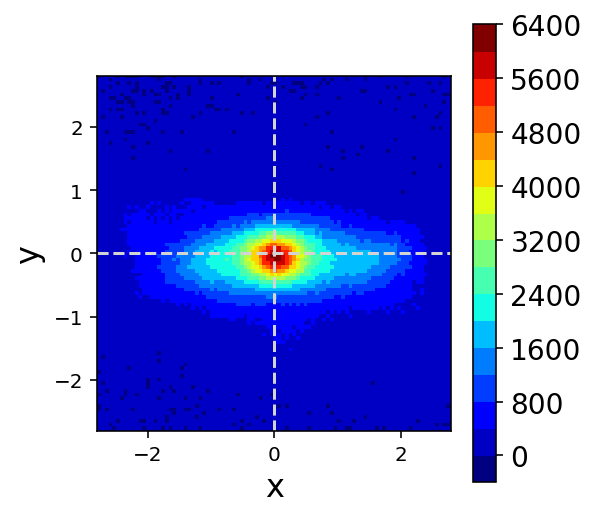

In [8]:
plot_image( data_info['image'], spaceGrid=data_info['spaceGrid'], xlim=[-2.8, 2.8])
#plot_image( data_info['image'], spaceGrid=data_info['spaceGrid'], xlim=[-1.2, 1.2])

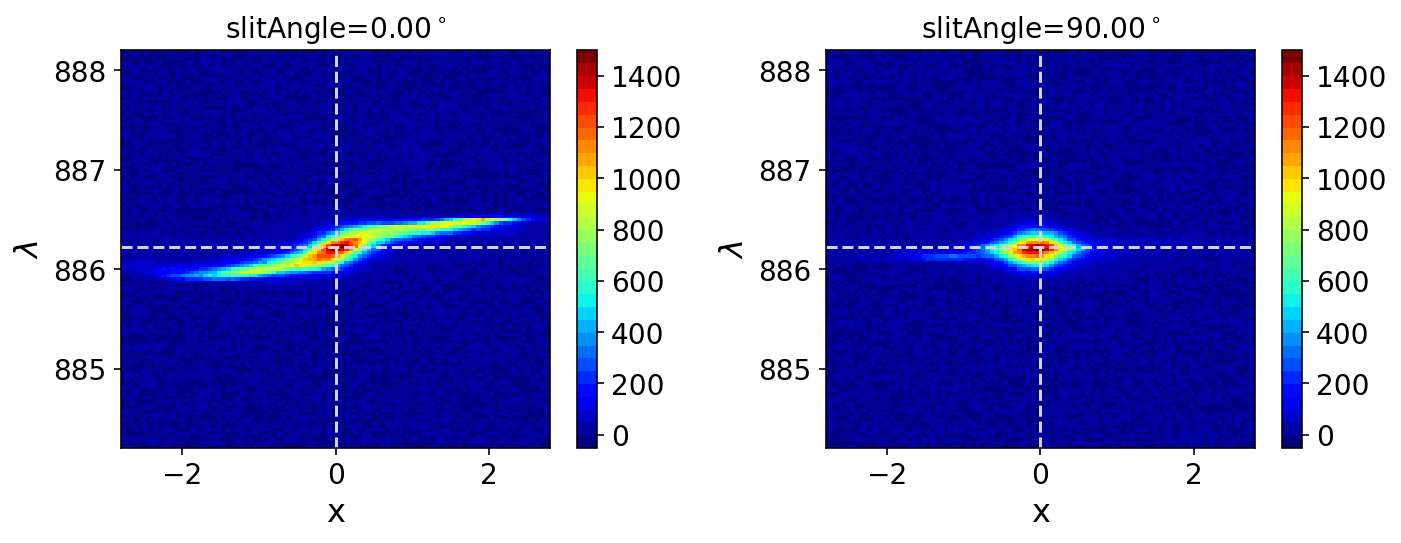

In [9]:
plot_specs(data_info['spec'], slitAngles=mock.Pars.fid['slitAngles'], spaceGrid=data_info['spaceGrid'], lambdaGrid=data_info['lambdaGrid'], xlim=[-2.8, 2.8])

In [11]:
dicta = {'a':3, 'b':4, 'c':30}

In [13]:
dicta['a']

3

In [15]:
from collections import Counter

responses = ['vanilla', 'chocolate', 'vanilla', 'vanilla', 'caramel', 'strawberry', 'vanilla']

In [16]:
Counter(responses).most_common

<bound method Counter.most_common of Counter({'vanilla': 4, 'chocolate': 1, 'caramel': 1, 'strawberry': 1})>

In [18]:
Counter(responses).most_common(1)

[('vanilla', 4)]

In [19]:
Counter(responses).most_common(1)[0]

('vanilla', 4)

In [20]:
Counter(responses).most_common(1)[0][0]

'vanilla'